## Introduction
In this notebook we will work with Wellbore report summaries from Norwegian Petroleum Directorate (NPD). The wellbore datasets are public domain.<br> They are available here: https://hotell.difi.no/?dataset=npd/wellbore/with-history (well report summaries).<br> The following link should go to all data available from Norwegian Oil Directorate, in public domain: https://data.norge.no/datasets/4304aea1-53b1-47ed-beae-52bf4d3642f3 (link might get broken over time).<br>
We will explore different NLP methods to extract insights and also create a few visualisations.
#### UNDER CONSTRUCTION, CHECK FOR UPDATES! :-))

#### How to fix blank maps and graph in jupyter lab!!
Check out link here: https://stackoverflow.com/questions/54936125/plotly-gives-an-empty-field-as-output-in-jupyter-lab <br>
To check if your jupyter lab plotly extension is up un running: > jupyter labextension list

---

In [1]:
import pandas as pd
import numpy as np
from pprint import pprint
import re, os, operator
import collections 
import matplotlib.pyplot as plt
import requests
import json

# import geopandas as gpd

import nltk
from nltk.corpus import stopwords

import altair as alt
import plotly.express as px
# add the line below if you use notebooks and comment it if you use jupyter lab
# alt.renderers.enable('notebook')

#### API connection - check for status
Make a general get request, print out status code. 
Status code = 200 means API connection is up and running.

In [2]:
requests.get('https://data.norge.no/api/dcat/870917732/data.json')

<Response [200]>

#### Get request - Well summaries
The datasets are paginated. The first page will tell us how many pages there are in total, and how many rows for the whole dataset.

In [3]:
wells_summary = requests.get('https://hotell.difi.no/api/json/npd/wellbore/with-history?page=1')
json_wells_summary = wells_summary.json()
print(f'number of pages: {json_wells_summary["pages"]}')
print(f'number of rows:  {json_wells_summary["posts"]}')

number of pages: 19
number of rows:  1824


#### Let's go through all the pages and append all the rows in JSON dictionary
Create a pandas dataframe from the json file

In [4]:
def get_all_data(url_dataset, json_count_page, df_out_name):
    '''looping through all pages,
    append in JSON dictionary,
    create dataframe
    '''
    
    page = json_count_page['pages']
    all_data_list = []
    for i in range(0, page):
        url = url_dataset + f'?page={i+1}'
        dataset_all = requests.get(url)
        dataset_all_json = dataset_all.json()
        number_of_entries = len(dataset_all_json['entries'])

        for entry in range(0, number_of_entries):
            all_data_list.append(dataset_all_json['entries'][entry])

    df_out_name = pd.DataFrame(all_data_list)
    return df_out_name

#### Getting all our well summaries into a dataframe

In [5]:
url_dataset ='https://hotell.difi.no/api/json/npd/wellbore/with-history'
df_out_name = 'df_all_summaries'
json_count_page = json_wells_summary  # total pagination number
df_all_summaries = get_all_data(url_dataset, json_count_page, df_out_name)

In [6]:
df_all_summaries.shape

(1824, 5)

In [7]:
df_all_summaries.head()

,wlbHistoryDateUpdated,wlbName,wlbNPDID_wellbore,wlbHistory,datesyncNPD
0,7/6/2016 12:00:00 AM,1/2-1,1382,<p><b>General</b></p>\n\n<p>Well 1/2-1 is loca...,20.01.2021
1,4/11/2017 12:00:00 AM,1/2-2,5192,<p>The 1/2-2 well was drilled to evaluate the ...,20.01.2021
2,5/19/2016 12:00:00 AM,1/3-1,154,<p class=MsoBodyText><b><span lang=EN-GB>Gener...,20.01.2021
3,4/11/2017 12:00:00 AM,1/3-10,5614,<p class=MsoBodyText><b><span lang=EN-GB>Gener...,20.01.2021
4,4/11/2017 12:00:00 AM,1/3-10 A,5779,<p class=MsoBodyText><b><span lang=EN-GB>Gener...,20.01.2021


#### Display a complete summary - we will need to clean all this html code!

In [8]:
# Display well summary (wlbHistory) 
df_all_summaries.iloc[1500]['wlbHistory']

'<p class=MsoBodyText><b><span lang=EN-GB>General</span></b></p>\n\n<p class=MsoBodyText><span lang=EN-GB>Well 6508/1-2 was drilled on the Skaugumsåsen\nprospect in the south-western end of the Helgeland Basin in the Norwegian Sea, about\nten kilometres south of the Norne field. The primary objective was to prove\npetroleum in reservoirs of the Early Jurassic Båt Group. A Secondary objective was\nto test the reservoir and HC potential of the Paleocene Tare Formation.</span></p>\n\n<p class=MsoBodyText><b><span lang=EN-GB>Operations and results</span></b></p>\n\n<p class=MsoBodyText><span lang=EN-GB>A 9 7/8&quot; pilot well 6508/1-U-2 was\ndrilled to 1305 m to check for shallow gas. No indications of shallow gas were\nseen. Wildcat well 6508/1-2 was spudded with the semi-submersible installation Aker\nBarents on 20 August 2011 and drilled to TD at 1810 m in the Early Jurassic\nTilje Formation. No significant problem was encountered in the operations. The\nwell was drilled with seawater 

#### Getting geolocation information for all wells - we will append this information to our well summary dataframe

In [9]:
wells_with_coordinates = requests.get('https://hotell.difi.no/api/json/npd/wellbore/with-coordinates?page=1')
json_wells_with_coordinates = wells_with_coordinates.json()
print(f'number of pages: {json_wells_with_coordinates["pages"]}')
print(f'number of rows:  {json_wells_with_coordinates["posts"]}')

number of pages: 85
number of rows:  8429


In [10]:
url_dataset = 'https://hotell.difi.no/api/json/npd/wellbore/with-coordinates'
df_out_name = 'df_all_with_coord'
json_count_page = json_wells_with_coordinates  # total pagination number
df_all_with_coord = get_all_data(url_dataset, json_count_page, df_out_name)

In [11]:
df_all_with_coord.shape

(8429, 26)

In [12]:
df_all_with_coord.head()

,wlbUtmZone,wlbWellType,wlbEwDeg,wlbEwCode,wlbEntryDate,wlbNsSec,wlbEwMin,wlbEwSec,wlbNsDecDeg,wlbProductionLicence,...,wlbEwUtm,wlbNsMin,wlbWellboreName,wlbContent,wlbDrillingOperator,wlbEwDesDeg,wlbNsUtm,wlbGeodeticDatum,datesyncNPD,wlbMainArea
0,31,EXPLORATION,2,E,20.03.1989,15.07,28,35.7,56.887519,143,...,468106.29,53,1/2-1,OIL,Phillips Petroleum Norsk AS,2.476583,6305128.26,ED50,20.01.2021,NORTH SEA
1,31,EXPLORATION,2,E,14.12.2005,32,29,47.66,56.992222,143 CS,...,469410.10,59,1/2-2,OIL SHOWS,Paladin Resources Norge AS,2.496572,6316774.33,ED50,20.01.2021,NORTH SEA
2,31,OTHER,2,E,09.05.2009,55.58,27,5.01,56.948772,143,...,466625.99,56,1/2-U-1,,ConocoPhillips Skandinavia AS,2.451392,6311958.73,ED50,20.01.2021,NORTH SEA
3,31,OTHER,2,E,12.05.2009,56.95,27,7.69,56.949153,143,...,466671.62,56,1/2-U-2,,ConocoPhillips Skandinavia AS,2.452136,6312000.73,ED50,20.01.2021,NORTH SEA
4,31,OTHER,2,E,12.05.2009,54.99,27,8.52,56.948608,143,...,466685.16,56,1/2-U-3,,ConocoPhillips Skandinavia AS,2.452367,6311940.01,ED50,20.01.2021,NORTH SEA


#### Having a quick check on a map with our dataframe with coordinates

In [13]:
df_all_with_coord['wlbNsDecDeg'] = df_all_with_coord['wlbNsDecDeg'].astype(float).round(3)
df_all_with_coord['wlbEwDesDeg'] = df_all_with_coord['wlbEwDesDeg'].astype(float).round(3)

In [14]:
df_all_with_coord.dtypes

wlbUtmZone               object
wlbWellType              object
wlbEwDeg                 object
wlbEwCode                object
wlbEntryDate             object
wlbNsSec                 object
wlbEwMin                 object
wlbEwSec                 object
wlbNsDecDeg             float64
wlbProductionLicence     object
wlbNsDeg                 object
wlbNpdidWellbore         object
wlbPurposePlanned        object
wlbField                 object
wlbNsCode                object
wlbCompletionDate        object
wlbEwUtm                 object
wlbNsMin                 object
wlbWellboreName          object
wlbContent               object
wlbDrillingOperator      object
wlbEwDesDeg             float64
wlbNsUtm                 object
wlbGeodeticDatum         object
datesyncNPD              object
wlbMainArea              object
dtype: object

#### Drawing scatter map function

In [15]:
def drawScatterMap(dataframe, colorColumn, title):
    fig = px.scatter_mapbox(dataframe, 
                            lat="wlbNsDecDeg", lon="wlbEwDesDeg", 
                            color=colorColumn, 
                            width=1000, height=1000, 
                            # color_discrete_sequence=["red", "green", "blue", "goldenrod", "magenta"],
                            color_discrete_sequence=px.colors.qualitative.D3,
                            center={'lat':71, 'lon':20},
                            zoom=3, 
                            # mapbox_style="stamen-watercolor",
                            mapbox_style="carto-positron",
                            title=title
                            )


    return fig.show()

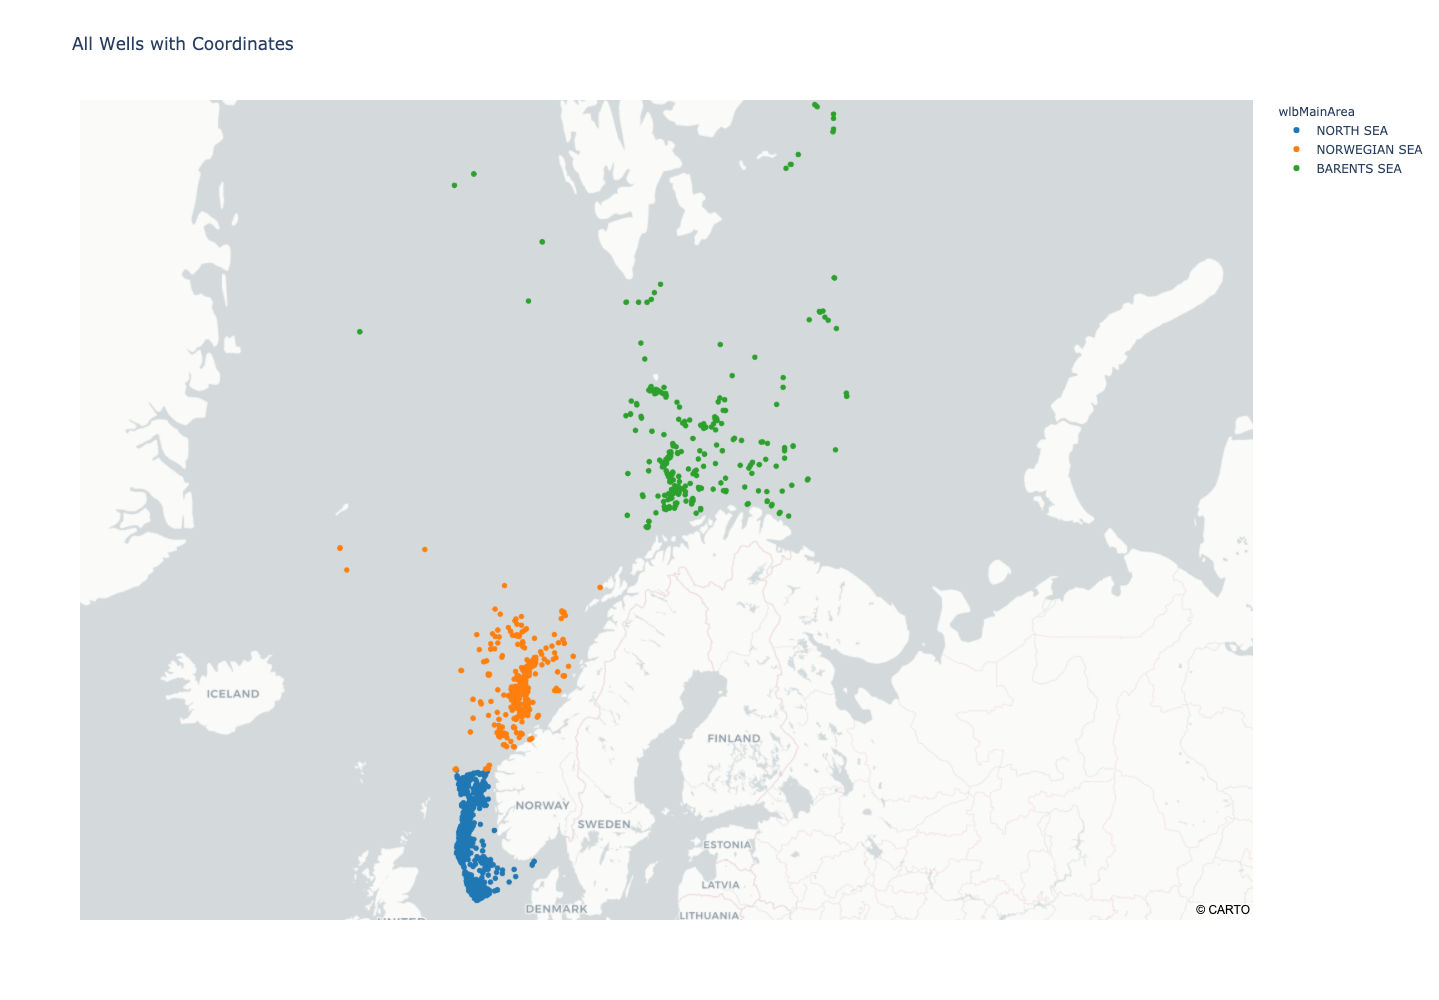

In [82]:
drawScatterMap(df_all_with_coord, 'wlbMainArea', 'All Wells with Coordinates')

In [17]:
df_all_with_coord.wlbMainArea.unique()

array(['NORTH SEA', 'NORWEGIAN SEA', 'BARENTS SEA'], dtype=object)

#### Merging df_all_with_coord together with df_all_summaries to get coordinates in the summary df

In [18]:
df_summaries_coord = pd.merge(df_all_summaries, 
                              df_all_with_coord[['wlbEwDesDeg', 'wlbNsDecDeg', 'wlbEwUtm', 'wlbNsUtm',
                                                   'wlbWellboreName', 'wlbContent', 'wlbMainArea', 'wlbDrillingOperator', 'wlbWellType']], how='left',
                              left_on='wlbName', right_on='wlbWellboreName')

In [19]:
df_summaries_coord.shape

(1824, 14)

In [20]:
df_summaries_coord.head()

,wlbHistoryDateUpdated,wlbName,wlbNPDID_wellbore,wlbHistory,datesyncNPD,wlbEwDesDeg,wlbNsDecDeg,wlbEwUtm,wlbNsUtm,wlbWellboreName,wlbContent,wlbMainArea,wlbDrillingOperator,wlbWellType
0,7/6/2016 12:00:00 AM,1/2-1,1382,<p><b>General</b></p>\n\n<p>Well 1/2-1 is loca...,20.01.2021,2.477,56.888,468106.29,6305128.26,1/2-1,OIL,NORTH SEA,Phillips Petroleum Norsk AS,EXPLORATION
1,4/11/2017 12:00:00 AM,1/2-2,5192,<p>The 1/2-2 well was drilled to evaluate the ...,20.01.2021,2.497,56.992,469410.10,6316774.33,1/2-2,OIL SHOWS,NORTH SEA,Paladin Resources Norge AS,EXPLORATION
2,5/19/2016 12:00:00 AM,1/3-1,154,<p class=MsoBodyText><b><span lang=EN-GB>Gener...,20.01.2021,2.851,56.856,490936.87,6301488.86,1/3-1,GAS,NORTH SEA,A/S Norske Shell,EXPLORATION
3,4/11/2017 12:00:00 AM,1/3-10,5614,<p class=MsoBodyText><b><span lang=EN-GB>Gener...,20.01.2021,2.706,56.928,482089.29,6309521.94,1/3-10,OIL/GAS,NORTH SEA,DONG E&P Norge AS,EXPLORATION
4,4/11/2017 12:00:00 AM,1/3-10 A,5779,<p class=MsoBodyText><b><span lang=EN-GB>Gener...,20.01.2021,2.706,56.928,482089.29,6309521.94,1/3-10 A,OIL/GAS,NORTH SEA,DONG E&P Norge AS,EXPLORATION


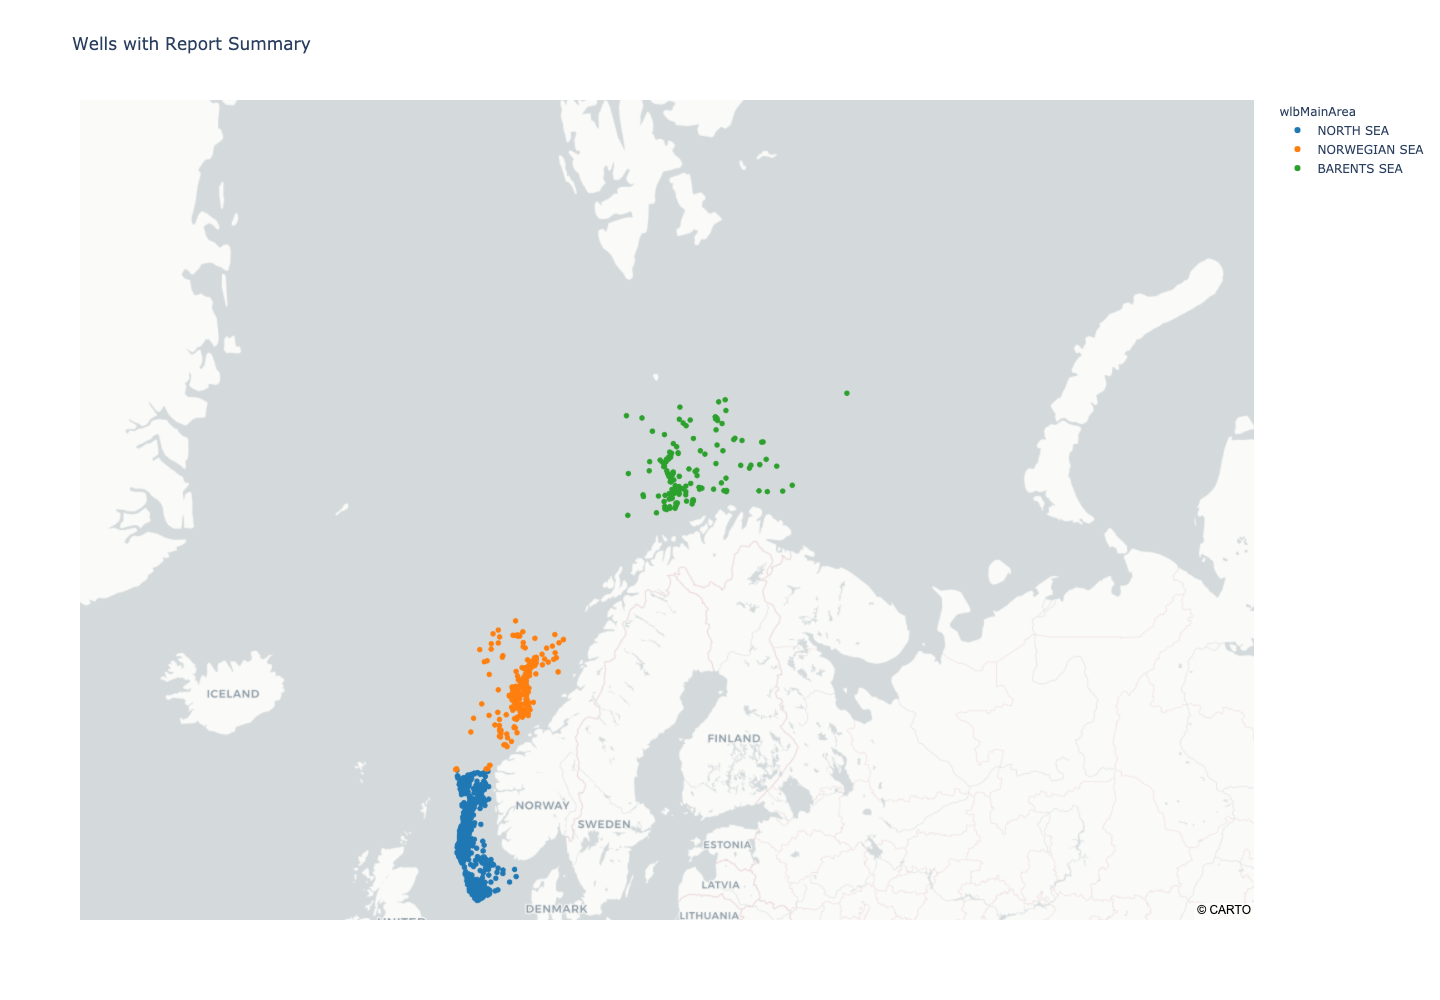

In [136]:
drawScatterMap(df_summaries_coord, 'wlbMainArea', 'Wells with Report Summary')

---

#### Removing tags from wlbHistory feature in df_summaries_coord + \n + replacing &quot with " with function 'cleanhtml'

In [22]:
# creating a copy of dataframe
df_summaries_coord_clean = df_summaries_coord.copy()
df_summaries_coord_clean.shape

(1824, 14)

In [23]:
# Basic cleaning of wlbHistory, we create new column 'wlbHistory_clean' with clean texts

def cleanhtml():
    # remove html tags
    cleanr = re.compile('<.*?>')
    
    rows = df_summaries_coord_clean['wlbHistory']
    listcleantext = []
    for r in rows:
        cleantext = re.sub(cleanr, '', r)
        
        # replace new line \n with empty space
        cleantext = cleantext.replace('\n', ' ')
        
        # replace &quot; with single quote (inch)
        cleantext = cleantext.replace('&quot;', "''")
        
        listcleantext.append(cleantext)
    df_summaries_coord_clean['wlbHistory_clean'] = listcleantext
    return

In [24]:
cleanhtml()

In [25]:
df_summaries_coord_clean.shape

(1824, 15)

In [26]:
df_summaries_coord_clean.head()

,wlbHistoryDateUpdated,wlbName,wlbNPDID_wellbore,wlbHistory,datesyncNPD,wlbEwDesDeg,wlbNsDecDeg,wlbEwUtm,wlbNsUtm,wlbWellboreName,wlbContent,wlbMainArea,wlbDrillingOperator,wlbWellType,wlbHistory_clean
0,7/6/2016 12:00:00 AM,1/2-1,1382,<p><b>General</b></p>\n\n<p>Well 1/2-1 is loca...,20.01.2021,2.477,56.888,468106.29,6305128.26,1/2-1,OIL,NORTH SEA,Phillips Petroleum Norsk AS,EXPLORATION,General Well 1/2-1 is located in the Central ...
1,4/11/2017 12:00:00 AM,1/2-2,5192,<p>The 1/2-2 well was drilled to evaluate the ...,20.01.2021,2.497,56.992,469410.10,6316774.33,1/2-2,OIL SHOWS,NORTH SEA,Paladin Resources Norge AS,EXPLORATION,The 1/2-2 well was drilled to evaluate the pro...
2,5/19/2016 12:00:00 AM,1/3-1,154,<p class=MsoBodyText><b><span lang=EN-GB>Gener...,20.01.2021,2.851,56.856,490936.87,6301488.86,1/3-1,GAS,NORTH SEA,A/S Norske Shell,EXPLORATION,General Well 1/3-1 was drilled on the crest o...
3,4/11/2017 12:00:00 AM,1/3-10,5614,<p class=MsoBodyText><b><span lang=EN-GB>Gener...,20.01.2021,2.706,56.928,482089.29,6309521.94,1/3-10,OIL/GAS,NORTH SEA,DONG E&P Norge AS,EXPLORATION,General Well 1/3-10 is located on the Hidra H...
4,4/11/2017 12:00:00 AM,1/3-10 A,5779,<p class=MsoBodyText><b><span lang=EN-GB>Gener...,20.01.2021,2.706,56.928,482089.29,6309521.94,1/3-10 A,OIL/GAS,NORTH SEA,DONG E&P Norge AS,EXPLORATION,General Well 1/3-10 A is located on the Hidra...


In [27]:
rawtext_sample = df_summaries_coord_clean.iloc[2]['wlbHistory']
# rawtext_sample

In [92]:
cleantext_sample = df_summaries_coord_clean.iloc[2]['wlbHistory_clean']
# cleantext_sample

In [29]:
# counting words in string (simple count based on white space between words)
len(cleantext_sample.split())

689

---

### Pre-processing for NLP

In [30]:
# gensim - topic modeling package
import gensim
from gensim.corpora import Dictionary
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.wrappers import LdaMallet

from wordcloud import WordCloud

In [31]:
# We continue with our dataframe 'df_summaries_coord_clean'

In [32]:
# Average length of texts in wlbHistory_clean

print('Average wlbHistory length: ' + str(df_summaries_coord_clean["wlbHistory_clean"].str.split().str.len().mean()))

Average wlbHistory length: 408.2450657894737


In [122]:
# Change all_text to list

wlbHistory_clean_to_list = df_summaries_coord_clean["wlbHistory_clean"].values.tolist()

# sample to analyse from the list
s1 = 2
s2 = 3

# pprint(wlbHistory_clean_to_list[:1])
pprint(wlbHistory_clean_to_list[s1:s2])

['General  Well 1/3-1 was drilled on the crest of a salt-induced anticline on '
 'the Hidra High in the North Sea. The purpose of the well was to investigate '
 'Tertiary and Mesozoic sequences down to top salt.  The well is Type Well for '
 'the Våle, Hidra, Hod, and Tor Formations, and Reference Well for the Vidar, '
 'Ekofisk and Blodøks Formations.  Operations and results  Well 1/3-1 was '
 'spudded with the four leg jack-up installation Orion on 6 July 1968 and '
 'drilled to TD at 4877 m in the Permian Zechstein Group. From the deviation '
 'survey it is seen that the well starts to deviate significantly at 4037 m (8 '
 'deg deviation), and at TD the deviation is 18 deg. This will correspond to a '
 'TVD RKB that is ca 25 m less than MD RKB.Several drilling problems occurred '
 "during the drilling operations of well 1/3-1. While drilling the 17 1/2'' "
 "hole for the 20'' casing, circulation losses started at 220 m (720') and "
 "became total at 238 m (781'). While drilling on w

In [123]:
# More cleaning

wlbHistory_clean_to_list2 = []

for sentence in range(0, len(wlbHistory_clean_to_list)):
    
    # Add spaces if two words appear to be concatenated by mistake
    # wlbHistory_ = re.sub(r'(\w)([A-Z])', r'\1 \2', str(wlbHistory_clean_to_list[sentence]))
    
    # Remove prefixed 'b', if present
    # wlbHistory_ = re.sub(r'^b\s+', '', wlbHistory_)
    
    # remove all numbers
    # wlbHistory_ = re.sub(r'\d+','', wlbHistory_)
    
    # Remove single characters from the start
    # wlbHistory_ = re.sub(r'\^[a-zA-Z]\s+', ' ', wlbHistory_)
    wlbHistory_ = re.sub(r'\^[a-zA-Z]\s+', ' ', str(wlbHistory_clean_to_list[sentence]))
    
    # Remove all the special characters
    wlbHistory_ = re.sub(r'\W', ' ', wlbHistory_)

    # Substituting multiple spaces with single space
    wlbHistory_ = re.sub(r'\s+', ' ', wlbHistory_, flags=re.I)

    wlbHistory_clean_to_list2.append(wlbHistory_)
    
pprint(wlbHistory_clean_to_list2[s1:s2])

['General Well 1 3 1 was drilled on the crest of a salt induced anticline on '
 'the Hidra High in the North Sea The purpose of the well was to investigate '
 'Tertiary and Mesozoic sequences down to top salt The well is Type Well for '
 'the Våle Hidra Hod and Tor Formations and Reference Well for the Vidar '
 'Ekofisk and Blodøks Formations Operations and results Well 1 3 1 was spudded '
 'with the four leg jack up installation Orion on 6 July 1968 and drilled to '
 'TD at 4877 m in the Permian Zechstein Group From the deviation survey it is '
 'seen that the well starts to deviate significantly at 4037 m 8 deg deviation '
 'and at TD the deviation is 18 deg This will correspond to a TVD RKB that is '
 'ca 25 m less than MD RKB Several drilling problems occurred during the '
 'drilling operations of well 1 3 1 While drilling the 17 1 2 hole for the 20 '
 'casing circulation losses started at 220 m 720 and became total at 238 m 781 '
 'While drilling on with sea water without returns 

In [124]:
# Change strings to bag-of-words

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

bag_of_words = list(sent_to_words(wlbHistory_clean_to_list2))

print(bag_of_words[s1:s2])

[['general', 'well', 'was', 'drilled', 'on', 'the', 'crest', 'of', 'salt', 'induced', 'anticline', 'on', 'the', 'hidra', 'high', 'in', 'the', 'north', 'sea', 'the', 'purpose', 'of', 'the', 'well', 'was', 'to', 'investigate', 'tertiary', 'and', 'mesozoic', 'sequences', 'down', 'to', 'top', 'salt', 'the', 'well', 'is', 'type', 'well', 'for', 'the', 'vale', 'hidra', 'hod', 'and', 'tor', 'formations', 'and', 'reference', 'well', 'for', 'the', 'vidar', 'ekofisk', 'and', 'blodøks', 'formations', 'operations', 'and', 'results', 'well', 'was', 'spudded', 'with', 'the', 'four', 'leg', 'jack', 'up', 'installation', 'orion', 'on', 'july', 'and', 'drilled', 'to', 'td', 'at', 'in', 'the', 'permian', 'zechstein', 'group', 'from', 'the', 'deviation', 'survey', 'it', 'is', 'seen', 'that', 'the', 'well', 'starts', 'to', 'deviate', 'significantly', 'at', 'deg', 'deviation', 'and', 'at', 'td', 'the', 'deviation', 'is', 'deg', 'this', 'will', 'correspond', 'to', 'tvd', 'rkb', 'that', 'is', 'ca', 'less', '

In [125]:
# Removing stop words from bag-of-words

stop_words = stopwords.words('english')
stop_words.extend(['formation', 'core', 'sm', 'well', 'zone']) # --> we can add extra words here that we want to remove from the bag of words

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

bag_of_words_no_stop = remove_stopwords(bag_of_words)

In [126]:
print(bag_of_words_no_stop[s1:s2])

[['general', 'drilled', 'crest', 'salt', 'induced', 'anticline', 'hidra', 'high', 'north', 'sea', 'purpose', 'investigate', 'tertiary', 'mesozoic', 'sequences', 'top', 'salt', 'type', 'vale', 'hidra', 'hod', 'tor', 'formations', 'reference', 'vidar', 'ekofisk', 'blodøks', 'formations', 'operations', 'results', 'spudded', 'four', 'leg', 'jack', 'installation', 'orion', 'july', 'drilled', 'td', 'permian', 'zechstein', 'group', 'deviation', 'survey', 'seen', 'starts', 'deviate', 'significantly', 'deg', 'deviation', 'td', 'deviation', 'deg', 'correspond', 'tvd', 'rkb', 'ca', 'less', 'md', 'rkb', 'several', 'drilling', 'problems', 'occurred', 'drilling', 'operations', 'drilling', 'hole', 'casing', 'circulation', 'losses', 'started', 'became', 'total', 'drilling', 'sea', 'water', 'without', 'returns', 'pipe', 'stuck', 'lost', 'circulation', 'eventually', 'sealed', 'cement', 'plug', 'tertiary', 'plastic', 'clays', 'problems', 'included', 'tight', 'hole', 'conditions', 'bit', 'balling', 'diffi

In [127]:
len(bag_of_words_no_stop) # --> this should still return the same length of our original 'df_all_summaries' dataframe :)

1824

### Creating WordCloud

In [128]:
# flatten 'bag_of_words_no_stop[s1:s2]' into a non nested list

t = bag_of_words_no_stop[s1:s2]
flat_list = []
for sublist in t:
    for item in sublist:
        flat_list.append(item)

In [129]:
print(flat_list)

['general', 'drilled', 'crest', 'salt', 'induced', 'anticline', 'hidra', 'high', 'north', 'sea', 'purpose', 'investigate', 'tertiary', 'mesozoic', 'sequences', 'top', 'salt', 'type', 'vale', 'hidra', 'hod', 'tor', 'formations', 'reference', 'vidar', 'ekofisk', 'blodøks', 'formations', 'operations', 'results', 'spudded', 'four', 'leg', 'jack', 'installation', 'orion', 'july', 'drilled', 'td', 'permian', 'zechstein', 'group', 'deviation', 'survey', 'seen', 'starts', 'deviate', 'significantly', 'deg', 'deviation', 'td', 'deviation', 'deg', 'correspond', 'tvd', 'rkb', 'ca', 'less', 'md', 'rkb', 'several', 'drilling', 'problems', 'occurred', 'drilling', 'operations', 'drilling', 'hole', 'casing', 'circulation', 'losses', 'started', 'became', 'total', 'drilling', 'sea', 'water', 'without', 'returns', 'pipe', 'stuck', 'lost', 'circulation', 'eventually', 'sealed', 'cement', 'plug', 'tertiary', 'plastic', 'clays', 'problems', 'included', 'tight', 'hole', 'conditions', 'bit', 'balling', 'diffic

In [130]:
len(flat_list)

324

In [131]:
# our list need to be a long string of words separated by space, in order to create the WordCloud

flat_list_to_string = ''
flat_list_to_string += " ".join(flat_list)+" "

In [132]:
print(flat_list_to_string)

general drilled crest salt induced anticline hidra high north sea purpose investigate tertiary mesozoic sequences top salt type vale hidra hod tor formations reference vidar ekofisk blodøks formations operations results spudded four leg jack installation orion july drilled td permian zechstein group deviation survey seen starts deviate significantly deg deviation td deviation deg correspond tvd rkb ca less md rkb several drilling problems occurred drilling operations drilling hole casing circulation losses started became total drilling sea water without returns pipe stuck lost circulation eventually sealed cement plug tertiary plastic clays problems included tight hole conditions bit balling difficulties lowering logging tools mud weight raised ppg ppg stabilize hole bit twisted retrieved second fishing run hydrocarbon bearing encountered mud became gas cut degasser overloaded circulation lost probably higher hole cement plug needed combat lost circulation problems decided set casing c

In [133]:
# define the WordCloud
wordcloud = WordCloud(width = 800, height = 800, 
            background_color ='white', 
            stopwords = stop_words, 
            min_font_size = 10).generate(flat_list_to_string)

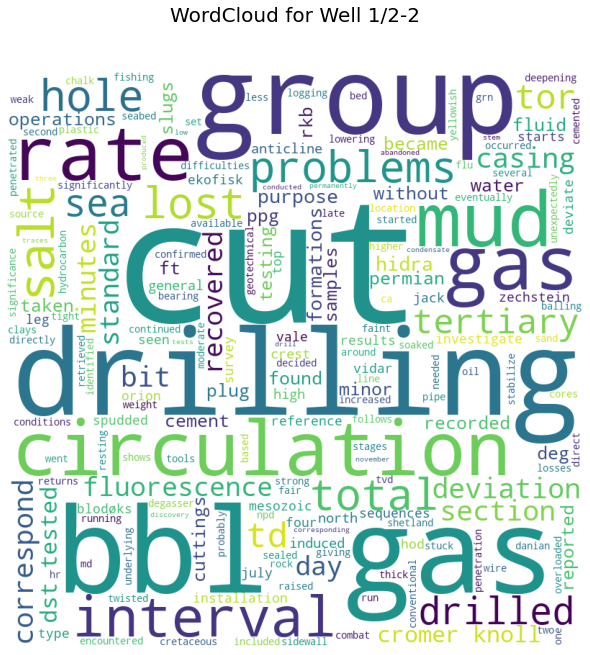

In [134]:
# plot the WordCloud image

plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title(label="WordCloud for Well 1/2-2\n\n",
             fontsize = 20,
             color = "black")

plt.show()

---

In [46]:
# Write df_all_summaries and df_all_with_coord into a CSV file to have a backup...
# df_all_summaries.to_csv(index=False)
# df_all_with_coord.to_csv(index=False)